Loaded 99422 rows with 46 columns.
            player_name player_color     opponent_name  player_elo  \
0  Kupreichik, Viktor D        white      Tal, Mikhail      2540.0   
1           Keres, Paul        white      Tal, Mikhail         NaN   
2          Tal, Mikhail        white  Keene, Raymond D         NaN   
3        Klovans, Janis        white      Tal, Mikhail         NaN   
4          Tal, Mikhail        white        Benko, Pal         NaN   

         date  eco                                       opening_name  \
0  1979-12-01  B97  Sicilian Defense: Najdorf Variation, Poisoned ...   
1  1961-10-16  D30      Queen's Gambit Declined: Capablanca Variation   
2  1964-01-10  B15                 Caro-Kann Defense: Alekhine Gambit   
3  1951-01-01  C52     Italian Game: Evans Gambit, Sokolsky Variation   
4  1959-01-01  B27              Modern Defense: Pterodactyl Variation   

  player_type  game_id   result  ...  blunder_count  top_move_alignment  \
0         NaN        0  1/2-1/

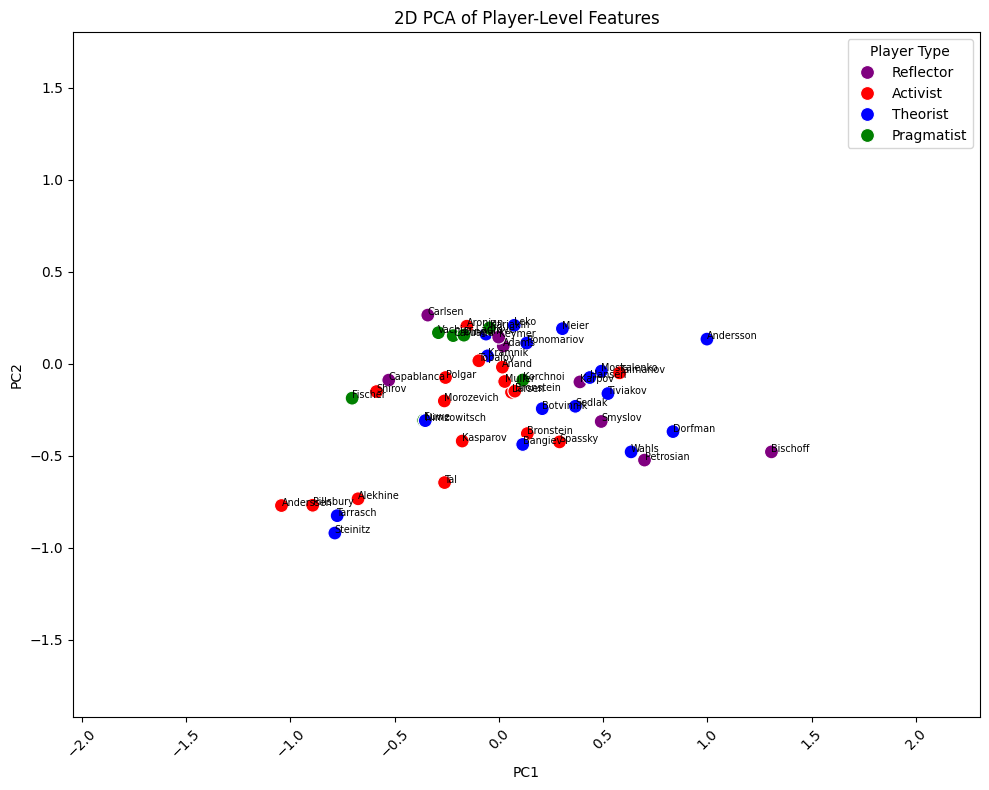

PCA (all features) explained variance ratios: [0.37423243 0.17988464 0.09914766]


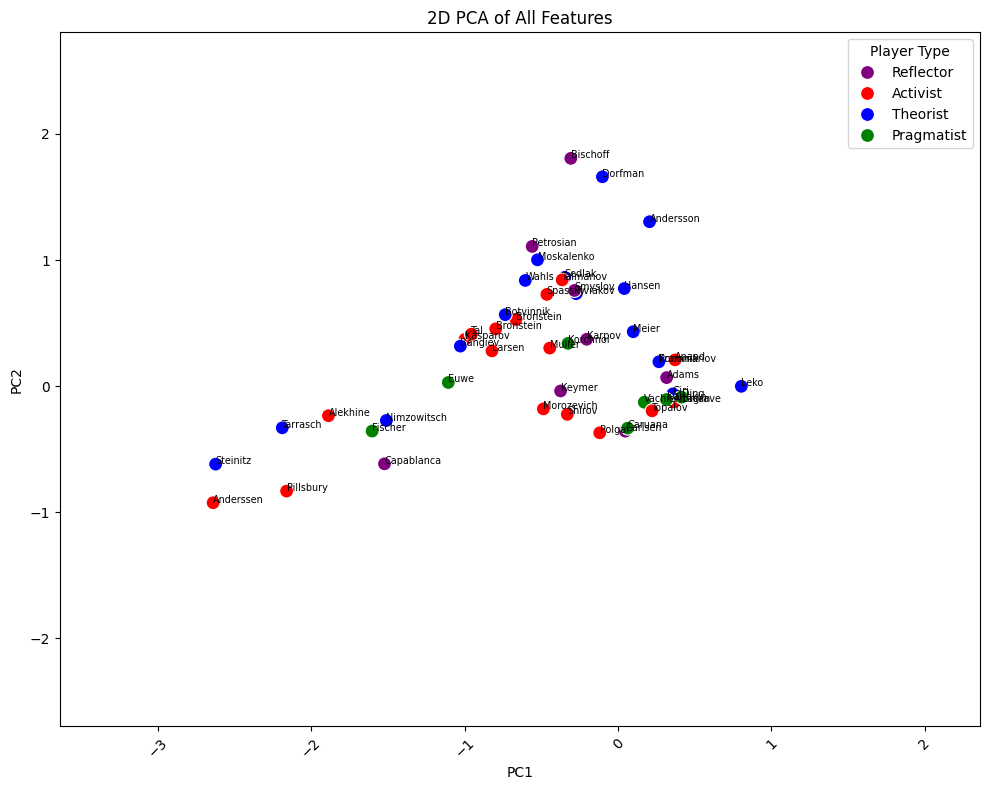

AUC for Activist: 0.7407407407407408
AUC for Pragmatist: 0.423076923076923
AUC for Reflector: 0.3076923076923077
AUC for Theorist: 0.76
Mean AUC Score (Decision Boundary Score): 0.5578774928774929


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1. Aggregate Game-Level Data to Player Level
# -------------------------------
def aggregate_player_data(players_df, min_games=3):
    """
    Aggregate game-level data into a player-level DataFrame.
    Only players with at least `min_games` games are included.
    Averages are computed for numeric features.
    'None' player types are replaced with 'Unknown'.
    Added: ECO rates, win/draw/lose rates, and outlier removal.
    """
    # Identify players with enough games
    game_counts = players_df['player_name'].value_counts()
    players_with_enough_games = game_counts[game_counts >= min_games].index.tolist()
    print(f"Found {len(players_with_enough_games)} players with at least {min_games} games.")

    # Filter to these players
    filtered_df = players_df[players_df['player_name'].isin(players_with_enough_games)].copy()

    # Columns that we will ignore for numeric aggregation
    ignore_cols = ['player_name', 'player_color', 'opponent_name', 'game_id', 'result', 'player_type', 'date', 'total_moves']
    numeric_cols = [col for col in filtered_df.columns
                    if col not in ignore_cols and pd.api.types.is_numeric_dtype(filtered_df[col])]
    
    # Impute missing values based on the mean of each player
    filtered_df[numeric_cols] = filtered_df.groupby('player_name')[numeric_cols].transform(lambda x: x.fillna(x.mean()))
    
    aggregated_data = []

    for player in players_with_enough_games:
        player_games = filtered_df[filtered_df['player_name'] == player].copy()
        
        # Get the first non-NaN player_type if available, default to 'Unknown'
        if 'player_type' in player_games.columns:
            p_type_series = player_games['player_type'].dropna()
            p_type = p_type_series.iloc[0] if not p_type_series.empty else 'Unknown'
        else:
            p_type = 'Unknown'
            
        # # STEP 1: Remove outlier games
        # if len(player_games) >= 5:  # Only attempt outlier removal if we have enough games
        #     # Create a style fingerprint for each game based on key metrics
        #     style_cols = ['top_move_alignment', 'top2_3_move_alignment', 'opening_length', 
        #                  'middlegame_length', 'endgame_length', 'material_balance_std']
            
        #     # Make sure we only use columns that exist and are truly numeric
        #     valid_style_cols = []
        #     for col in style_cols:
        #         if col in player_games.columns:
        #             # Check if the column is numeric and has no strings
        #             try:
        #                 # Convert to numeric, coercing errors to NaN
        #                 player_games[col] = pd.to_numeric(player_games[col], errors='coerce')
        #                 # Only include the column if it has valid numeric values
        #                 if not player_games[col].isna().all():
        #                     valid_style_cols.append(col)
        #             except:
        #                 print(f"Warning: Could not convert column {col} to numeric for player {player}")
            
        #     if valid_style_cols:
        #         # Calculate Z-scores for each valid style metric
        #         for col in valid_style_cols:
        #             # Skip calculation if standard deviation is zero or column has NaNs
        #             if player_games[col].std() > 0 and not player_games[col].isna().any():
        #                 player_games[f'{col}_zscore'] = np.abs((player_games[col] - player_games[col].mean()) / player_games[col].std())
                
        #         # Calculate mean Z-score across all metrics for each game
        #         zscore_cols = [f'{col}_zscore' for col in valid_style_cols if f'{col}_zscore' in player_games.columns]
        #         if zscore_cols:
        #             player_games['style_deviation'] = player_games[zscore_cols].mean(axis=1)
                    
        #             # Identify outliers (games with style_deviation > 2)
        #             outliers = player_games[player_games['style_deviation'] > 2]
                    
        #             if len(outliers) > 0:
        #                 print(f"Removing {len(outliers)} outlier games for {player} (keeping {len(player_games) - len(outliers)})")
        #                 player_games = player_games[player_games['style_deviation'] <= 2]
        
        # Initialize player statistics
        player_stats = {
            'player_name': player,
            'player_type': p_type,
            'num_games': len(player_games)
        }
        
        # STEP 2: Add ECO rates (opening categories)
        if 'eco' in player_games.columns:
            # Extract the main ECO category (first letter: A, B, C, D, E)
            player_games['eco_category'] = player_games['eco'].astype(str).str[0]
            
            # Calculate frequency of each category
            eco_counts = player_games['eco_category'].value_counts(normalize=True)
            
            # Add each ECO category frequency
            for category in ['A', 'B', 'C', 'D', 'E']:
                player_stats[f'eco_{category}_rate'] = eco_counts.get(category, 0.0)
                
            # Add diversity of openings metric
            player_stats['opening_diversity'] = len(player_games['eco'].unique()) / len(player_games)
        
        # STEP 3: Add win/draw/loss rates
        if 'result' in player_games.columns and 'player_color' in player_games.columns:
            # Overall statistics
            player_stats['win_rate'] = ((player_games['player_color'] == 'white') & (player_games['result'] == '1-0') | 
                                       (player_games['player_color'] == 'black') & (player_games['result'] == '0-1')).mean()
            
            player_stats['draw_rate'] = (player_games['result'] == '1/2-1/2').mean()
            
            player_stats['loss_rate'] = ((player_games['player_color'] == 'white') & (player_games['result'] == '0-1') | 
                                        (player_games['player_color'] == 'black') & (player_games['result'] == '1-0')).mean()
            
            # White statistics
            white_games = player_games[player_games['player_color'] == 'white']
            if len(white_games) > 0:
                player_stats['white_game_rate'] = len(white_games) / len(player_games)
                player_stats['white_win_rate'] = (white_games['result'] == '1-0').mean()
                player_stats['white_draw_rate'] = (white_games['result'] == '1/2-1/2').mean()
                player_stats['white_loss_rate'] = (white_games['result'] == '0-1').mean()
            else:
                player_stats['white_game_rate'] = 0
                player_stats['white_win_rate'] = 0
                player_stats['white_draw_rate'] = 0
                player_stats['white_loss_rate'] = 0
            
            # Black statistics
            black_games = player_games[player_games['player_color'] == 'black']
            if len(black_games) > 0:
                player_stats['black_game_rate'] = len(black_games) / len(player_games)
                player_stats['black_win_rate'] = (black_games['result'] == '0-1').mean()
                player_stats['black_draw_rate'] = (black_games['result'] == '1/2-1/2').mean()
                player_stats['black_loss_rate'] = (black_games['result'] == '1-0').mean()
            else:
                player_stats['black_game_rate'] = 0
                player_stats['black_win_rate'] = 0
                player_stats['black_draw_rate'] = 0
                player_stats['black_loss_rate'] = 0
        
        # STEP 4: Compute original averages for each numeric feature (as in the original code)
        for col in numeric_cols:
            # Ensure the column is numeric before calculating mean
            try:
                # Convert to numeric, coercing errors to NaN
                numeric_values = pd.to_numeric(player_games[col], errors='coerce')
                # Only calculate mean if we have valid numeric values
                if not numeric_values.isna().all():
                    player_stats[col] = numeric_values.mean()
                else:
                    player_stats[col] = np.nan
            except:
                player_stats[col] = np.nan
            
        aggregated_data.append(player_stats)

    agg_df = pd.DataFrame(aggregated_data)
    
    # Report feature count
    feature_count = len(agg_df.columns) - 3  # Subtract player_name, player_type, num_games
    print(f"Created {feature_count} features for each player")
    
    return agg_df

# -------------------------------
# Step 2. Select Best Features using RandomForest Importance
# -------------------------------
def select_best_features(agg_df, n_features=15, importance_threshold=0.1):
    """
    Select best numeric features using RandomForestClassifier importance
    with 'player_type' as the target.
    """
    metadata = ['player_name', 'player_type', 'num_games']
    print(f"Selecting best features from {len(agg_df)} players with {len(agg_df.columns)} columns.")
    print(f"All features: {agg_df.columns.tolist()}")
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]


    # drop unknown players
    agg_df = agg_df[agg_df['player_type'] != 'Unknown']
    # reset index to avoid KeyError when accessing rows by position
    agg_df = agg_df.reset_index(drop=True)
   
    X = agg_df[numeric_cols]
    y = agg_df['player_type']
    



    # Encode player_type as numeric
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Impute and scale
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train RandomForest classifier
    rf = RandomForestClassifier(n_estimators=2500, random_state=42)
    rf.fit(X_scaled, y_encoded)

    importances = rf.feature_importances_
    importance_series = pd.Series(importances, index=numeric_cols)

    # Normalize importances to the maximum value
    importance_series = importance_series / importance_series.max()

    # Select features above the importance threshold
    selected = importance_series[importance_series > importance_threshold].index.tolist()

    # If more than desired n_features, choose the top n_features based on importance
    if len(selected) > n_features:
        selected = importance_series.sort_values(ascending=False).index[:n_features].tolist()

    print("Selected features:", selected)
    return selected

# -------------------------------
# Step 3. Apply PCA to Selected Features
# -------------------------------
def apply_pca(agg_df, features, n_components=3):
    """
    Scale the selected features, apply PCA and return the transformed data.
    """
    X = agg_df[features]
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()

    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")
    return X_pca, pca

def apply_pca_all_features(agg_df, n_components=2):
    """
    Apply PCA to all numeric features (without any feature selection)
    for a 2D visualization.
    """
    metadata = ['player_name', 'player_type', 'num_games']
    numeric_cols = [col for col in agg_df.columns 
                    if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]
    
    X = agg_df[numeric_cols]
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)
    
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA (all features) explained variance ratios: {pca.explained_variance_ratio_}")
    return X_pca, pca

# -------------------------------
# Step 4. Visualize 2D PCA Result using Seaborn
# -------------------------------
def visualize_2d_pca(agg_df, X_pca_2d, title='2D PCA of Player-Level Features'):
    """
    Visualize 2D PCA result using a scatter plot.
    Points are colored by player_type and labeled by player_name.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_2d[:, 0],
        'PC2': X_pca_2d[:, 1],
        'player_type': agg_df['player_type'], # Should now contain 'Unknown' instead of None
        'player_name': agg_df['player_name']
    })
    
    # Filter out unknown players AFTER creating the dataframe with all the data
    pca_df = pca_df[pca_df['player_type'] != 'Unknown']
    
    # hide activist 
    # pca_df = pca_df[pca_df['player_type'] != 'Activist']
    
    # hide pragmatist
    # pca_df = pca_df[pca_df['player_type'] != 'Pragmatist']
    
    # hide reflector
    # pca_df = pca_df[pca_df['player_type'] != 'Reflector']
    
    # hide theorist
    # pca_df = pca_df[pca_df['player_type'] != 'Theorist']
    
    # Reset the index to avoid KeyError when accessing rows by position
    pca_df = pca_df.reset_index(drop=True)

    plt.figure(figsize=(10, 8))
    # Define the palette, using 'Unknown' as the key for gray
    palette = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray' # Changed None key to 'Unknown'
    }
    ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='player_type',
                         palette=palette, s=100)

    # Add labels for each point
    for line in range(0,pca_df.shape[0]):
         player_name = pca_df.player_name[line]
         if ', ' in player_name:
             last_name = player_name.split(', ')[0]
             ax.text(pca_df.PC1[line], pca_df.PC2[line], last_name, horizontalalignment='left', size='x-small', color='black')
         else:
             ax.text(pca_df.PC1[line], pca_df.PC2[line], player_name, horizontalalignment='left', size='x-small', color='black')

    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Player Type')
    plt.xlim(X_pca_2d[:, 0].min() - 1, X_pca_2d[:, 0].max() + 1)
    plt.ylim(X_pca_2d[:, 1].min() - 1, X_pca_2d[:, 1].max() + 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Step 5. Create Interactive 3D PCA Visualization using Plotly Express
# -------------------------------
def visualize_3d_pca(agg_df, X_pca_3d):
    """
    Create an interactive 3D scatter plot of the PCA result using Plotly Express.
    Points are colored by player_type.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_3d[:, 0],
        'PC2': X_pca_3d[:, 1],
        'PC3': X_pca_3d[:, 2],
        'player_type': agg_df['player_type'], # Should now contain 'Unknown' instead of None
        'player_name': agg_df['player_name']
    })

    # Define the color map, using 'Unknown' as the key for gray
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'  # Changed None key to 'Unknown'
    }

    fig = px.scatter_3d(
        pca_df,
        x='PC1', y='PC2', z='PC3',
        color='player_type',
        hover_data=['player_name'],
        color_discrete_map=color_map,
        title='Interactive 3D PCA of Player-Level Features'
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

# -------------------------------
# Step 6. Decision Boundary Score (AUC)
# -------------------------------
def calculate_decision_boundary_score(agg_df):
    """
    Calculates the Area Under the ROC Curve (AUC) for a RandomForestClassifier
    predicting player_type.  Uses the selected features from the
    select_best_features function.  Prints AUC for each class and the mean AUC.
    """

    # Prepare data
    agg_df = agg_df.copy()
    
    # Skip unknown players
    agg_df = agg_df[agg_df['player_type'] != 'Unknown']
    
    le = LabelEncoder()
    agg_df['player_type'] = le.fit_transform(agg_df['player_type'])  # Numerical labels

    # Select features (using the same logic as before)
    metadata = ['player_name', 'player_type', 'num_games']
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]

    X = agg_df[numeric_cols]
    y = agg_df['player_type']
    
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))

    # Impute and Scale
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Train RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=5000, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = rf_classifier.predict_proba(X_test)

    # Calculate AUC (one-vs-rest for multiclass)
    auc_scores = {}
    for i in range(len(le.classes_)):
        try:
            auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
            auc_scores[le.inverse_transform([i])[0]] = auc
            print(f"AUC for {le.inverse_transform([i])[0]}: {auc}")
        except ValueError as e:
            class_name = le.inverse_transform([i])[0]
            print(f"ValueError calculating AUC for class {class_name}: {e}")
            auc_scores[class_name] = 0.5  # Assign a neutral value if AUC cannot be computed

    mean_auc = np.mean(list(auc_scores.values()))

    print(f"Mean AUC Score (Decision Boundary Score): {mean_auc}")
    return mean_auc


# -------------------------------
# Main Function
# -------------------------------
def main():
    # Load the game-level data
    input_file = 'player_centric_data.csv'  # Adjust the file path as necessary
    df = pd.read_csv(input_file)
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns.")
    print(df.head())

    # Aggregate to player level (using a minimum game threshold, e.g., 100)
    # This will now replace None player_types with 'Unknown'
    agg_df = aggregate_player_data(df, min_games=100)

    # Select best features based on importance
    selected_features = select_best_features(agg_df, n_features=15, importance_threshold=0.1)

    # Apply PCA for 3 components
    X_pca, pca_model = apply_pca(agg_df, selected_features, n_components=3)

    # Visualize the first 2 components (2D PCA)
    # The palette now correctly maps 'Unknown' to gray
    visualize_2d_pca(agg_df, X_pca[:, :2])

    # Create an interactive 3D PCA visualization
    # The color map now correctly maps 'Unknown' to gray
    # visualize_3d_pca(agg_df, X_pca)
    
    
    # apply PCA to all features for 2D visualization
    X_pca_all, pca_model_all = apply_pca_all_features(agg_df, n_components=3)
    visualize_2d_pca(agg_df, X_pca_all[:, :2], title='2D PCA of All Features')
    # Create an interactive 3D PCA visualization for all features
    # visualize_3d_pca(agg_df, X_pca_all)

    # Calculate and print decision boundary score (AUC)
    calculate_decision_boundary_score(agg_df)

if __name__ == "__main__":
    main()

Loaded 99422 rows with 46 columns.
Found 96 players with at least 100 games.
Created 52 features for each player

Assigned player types for 1 players from provided lists
Assigned eras for 48 players

Player Era Categorization:
  Unknown Era: 48 players
  Computer Age: 30 players
  Pre-Computer Age: 18 players

Player Types in Computer Age:
  Theorist: 14 players
  Activist: 7 players
  Reflector: 5 players
  Pragmatist: 4 players

Player Types in Pre-Computer Age:
  Activist: 8 players
  Theorist: 4 players
  Pragmatist: 3 players
  Reflector: 3 players

Player Types in Unknown Era:
  Unknown: 46 players
  Activist: 2 players

ANALYSIS WITH SELECTED FEATURES

Selected features: ['space_advantage', 'material_changes', 'top2_3_move_alignment', 'endgame_length', 'eco_B_rate', 'brilliant_count', 'vulnerability_spikes', 'center_control_avg', 'check_frequency', 'sharpness', 'middlegame_length', 'sacrifice_count', 'piece_mobility_avg', 'minor_piece_development', 'king_safety']

PCA on Selecte

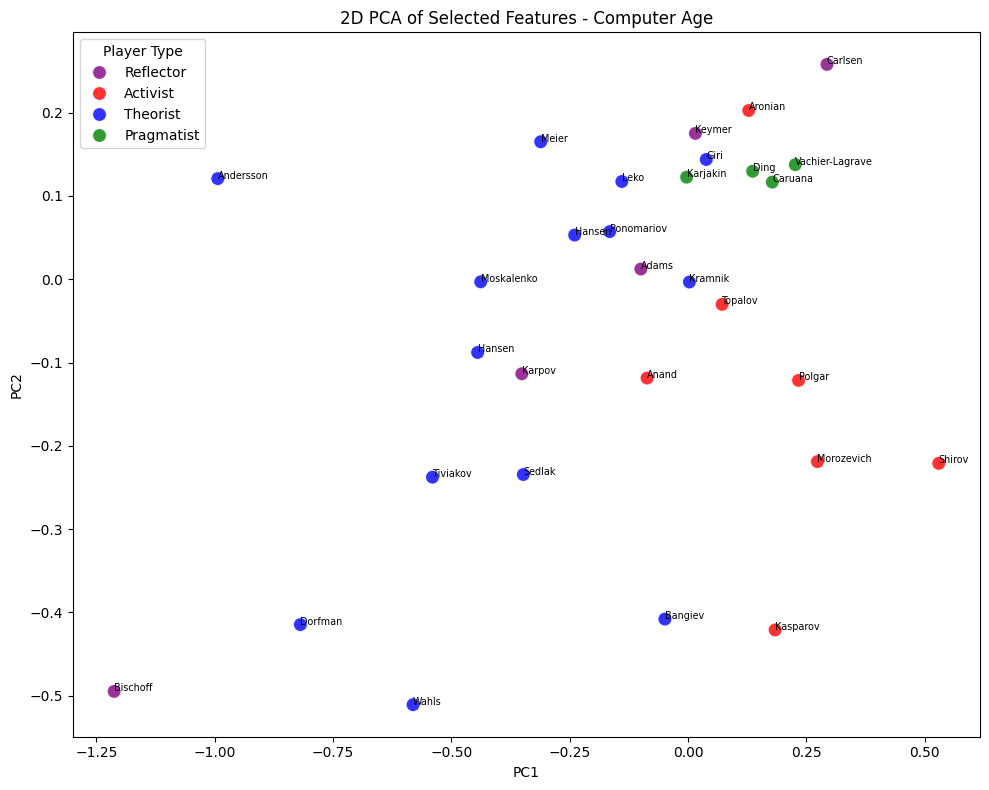

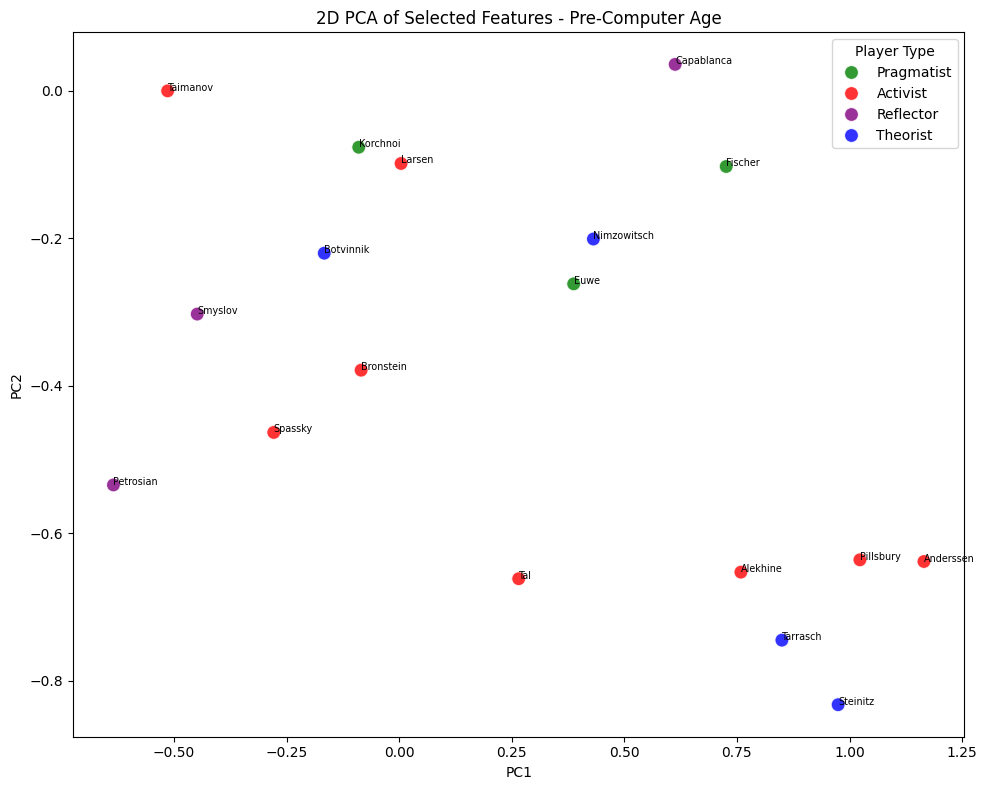

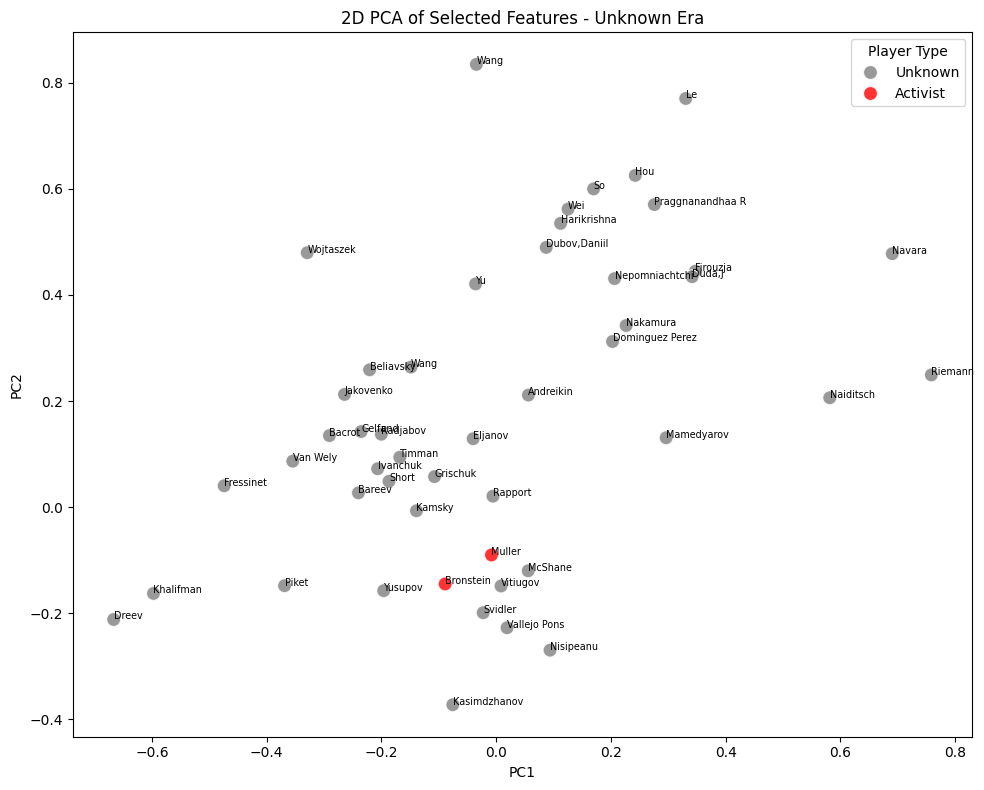

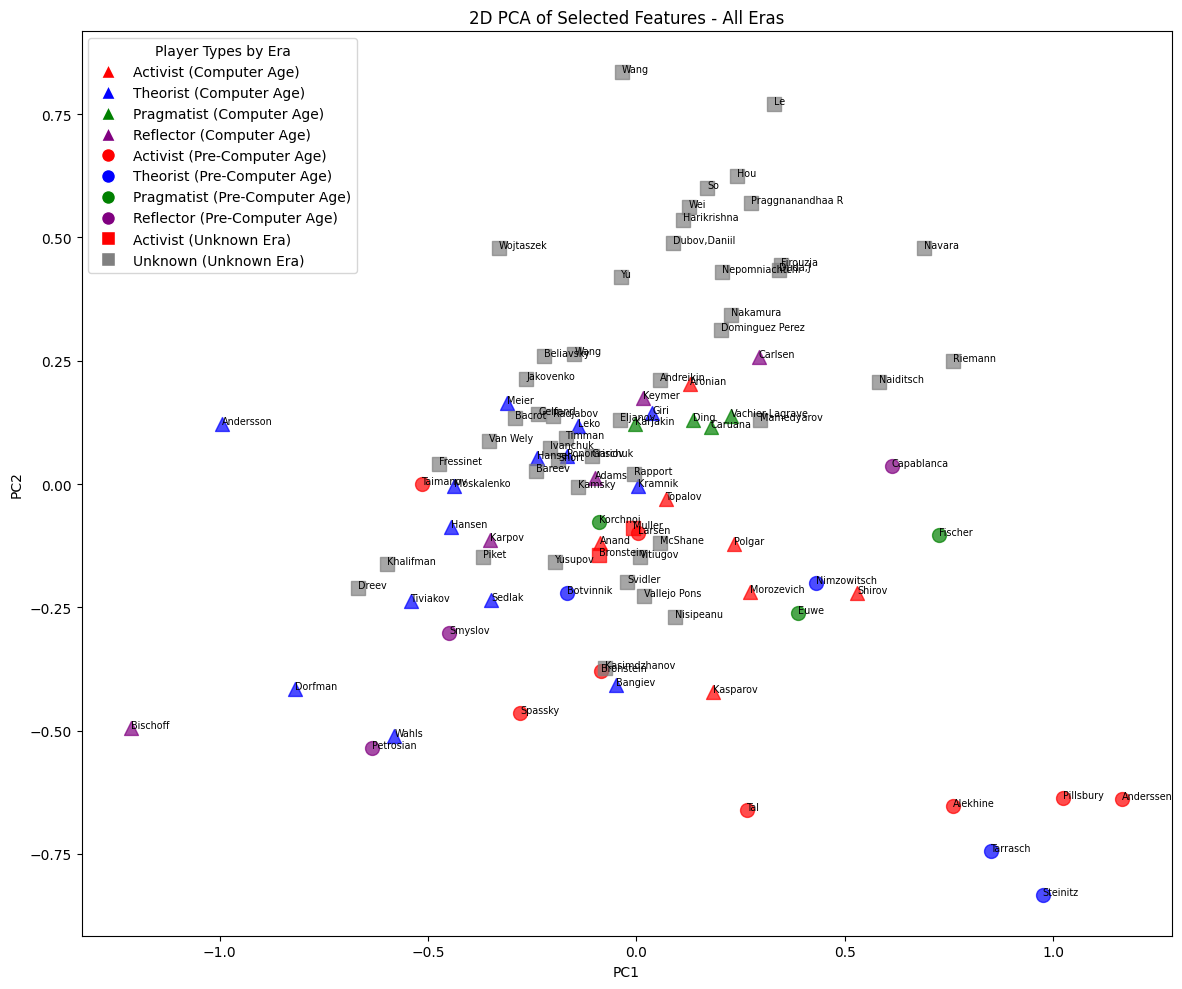


Calculating Decision Boundary Score with Selected Features:
Number of features used: 15

Decision Boundary Score for Computer Age:
  AUC for Activist: 0.7857
  AUC for Pragmatist: 0.2500
  AUC for Reflector: 0.6429
  AUC for Theorist: 0.9000
  Mean AUC Score for Computer Age: 0.6446

Decision Boundary Score for Pre-Computer Age:
  AUC for Activist: 0.7222
  AUC for Pragmatist: 0.2000
  AUC for Reflector: 1.0000
  AUC for Theorist: 0.7000
  Mean AUC Score for Pre-Computer Age: 0.6556

Decision Boundary Score for Unknown Era:
  AUC for Activist: 1.0000
  AUC for Unknown: 1.0000
  Mean AUC Score for Unknown Era: 1.0000

Calculating Combined Decision Boundary Score with Selected Features:
  AUC for Activist: 0.6458
  AUC for Pragmatist: 0.4722
  AUC for Reflector: 0.7963
  AUC for Theorist: 0.5688
  AUC for Unknown: 0.8000
Combined Mean AUC Score with Selected Features: 0.6566

ANALYSIS WITH ALL FEATURES

PCA on All Features:
Number of features used: 52
Explained variance ratios: [0.37494

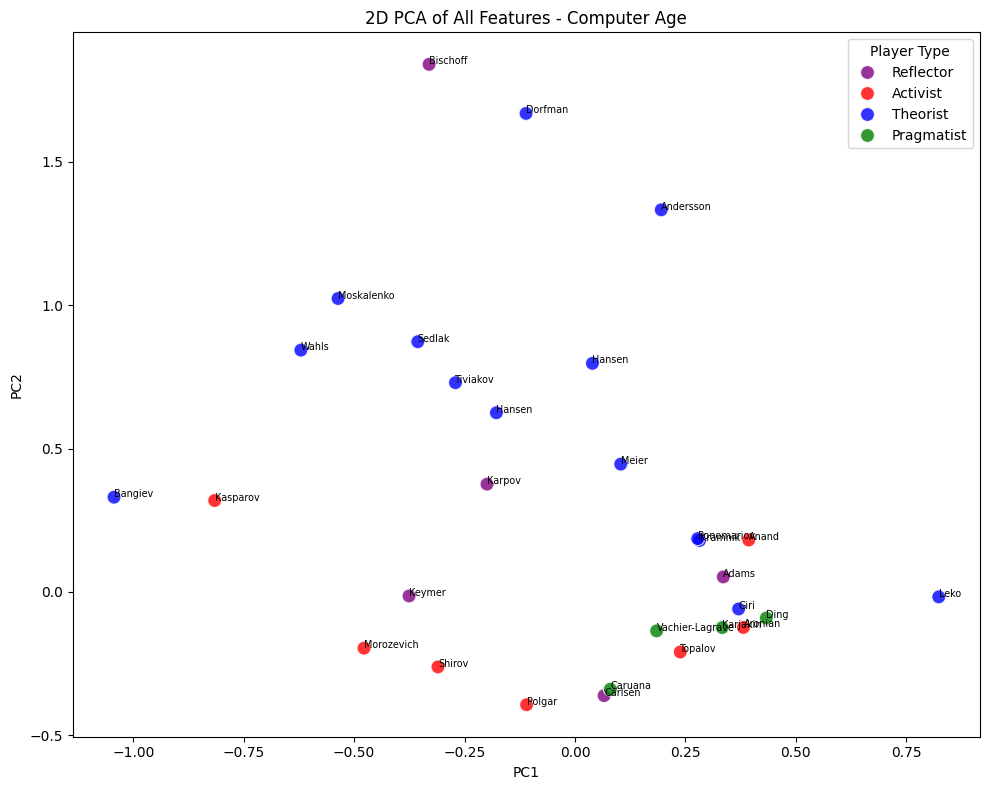

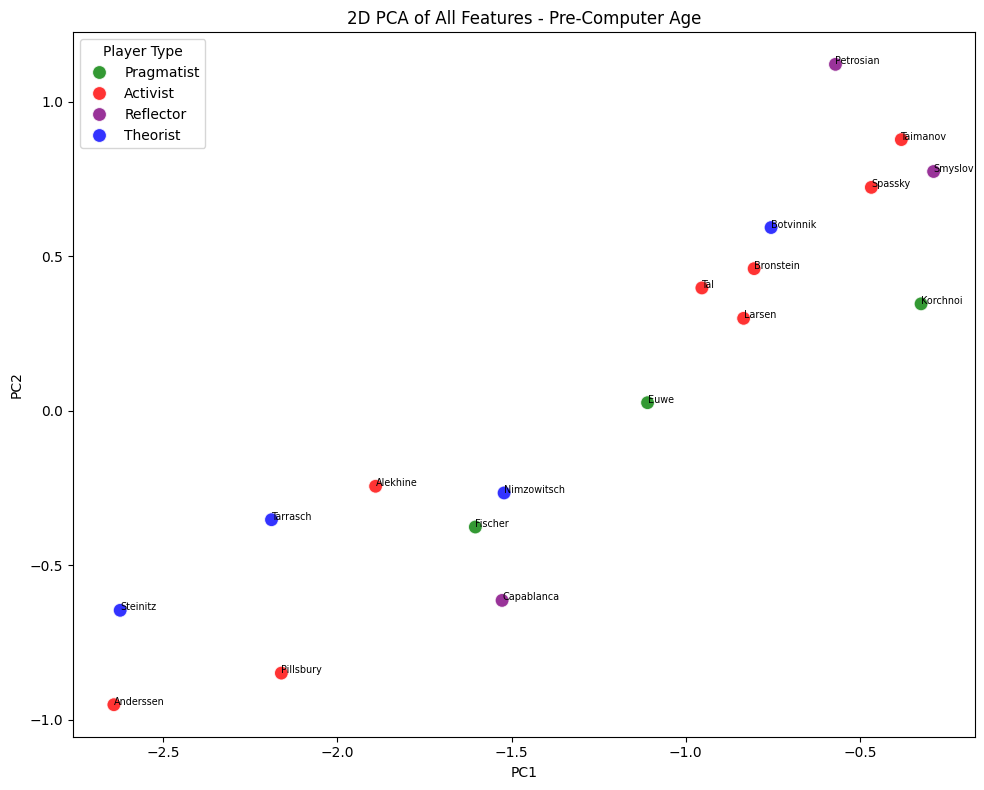

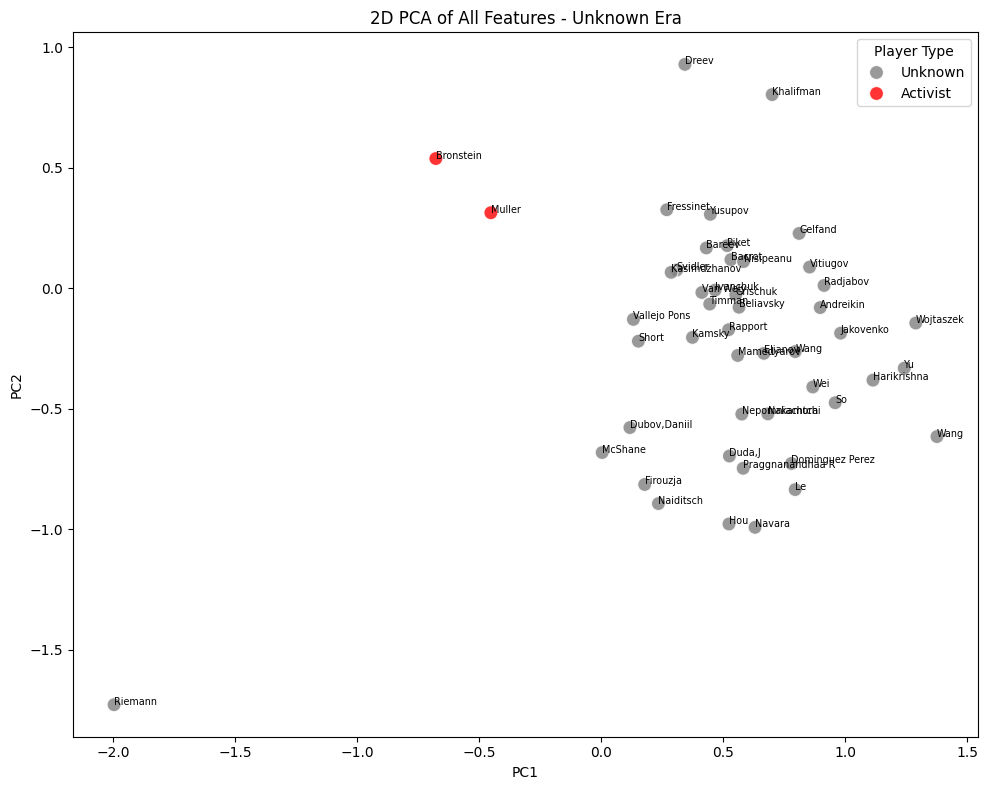

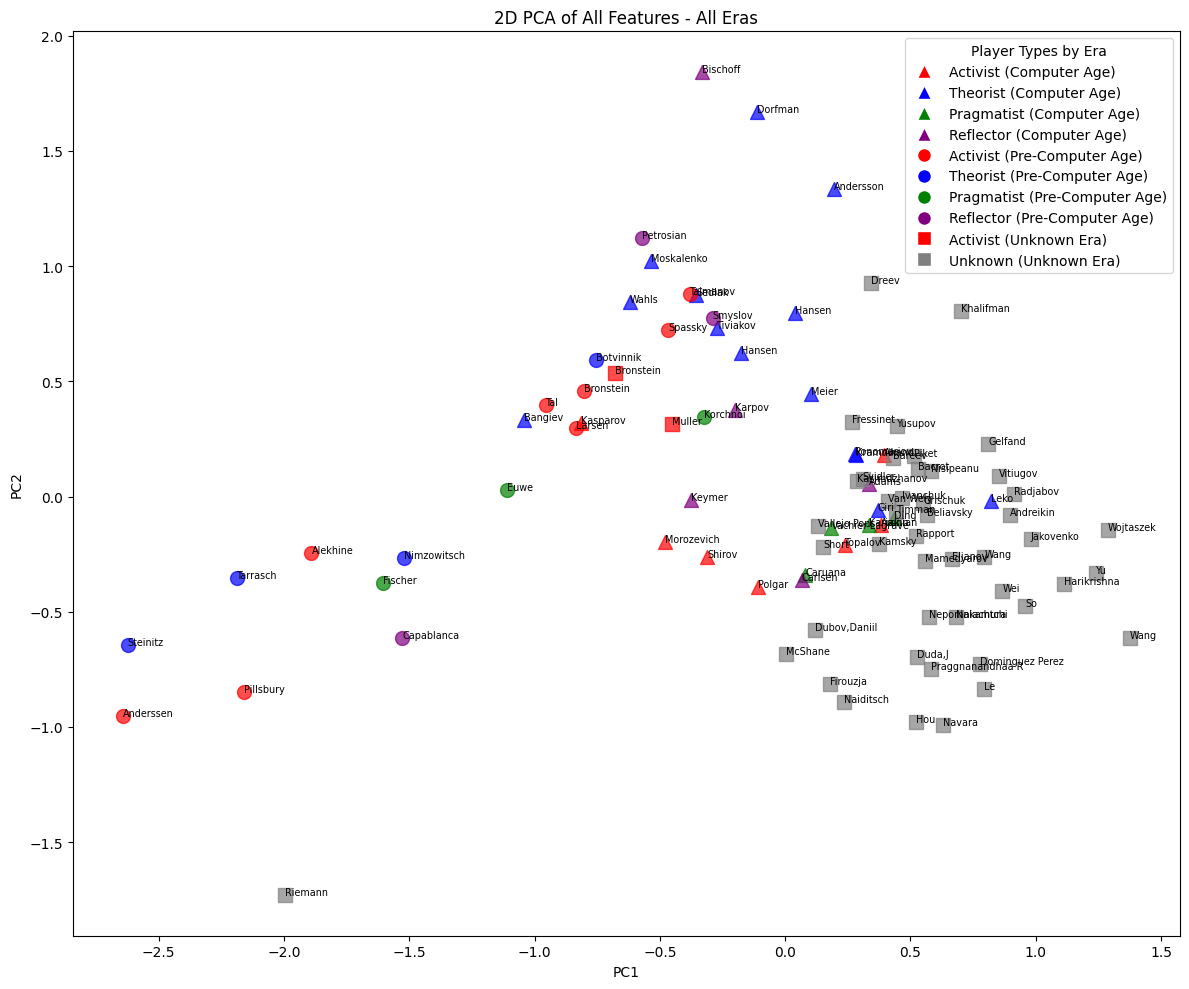


Calculating Decision Boundary Score with All Features:
Number of features used: 52

Decision Boundary Score for Computer Age:
  AUC for Activist: 0.6071
  AUC for Pragmatist: 0.3125
  AUC for Reflector: 0.4286
  AUC for Theorist: 0.8500
  Mean AUC Score for Computer Age: 0.5496

Decision Boundary Score for Pre-Computer Age:
  AUC for Activist: 0.3333
  AUC for Pragmatist: 0.0000
  AUC for Reflector: 1.0000
  AUC for Theorist: 0.8000
  Mean AUC Score for Pre-Computer Age: 0.5333

Decision Boundary Score for Unknown Era:
  AUC for Activist: 1.0000
  AUC for Unknown: 1.0000
  Mean AUC Score for Unknown Era: 1.0000

Calculating Combined Decision Boundary Score with All Features:
  AUC for Activist: 0.7583
  AUC for Pragmatist: 0.9074
  AUC for Reflector: 0.6667
  AUC for Theorist: 0.7065
  AUC for Unknown: 1.0000
Combined Mean AUC Score with All Features: 0.8078

COMPARISON OF RESULTS
AUC with Selected Features (15 features): 0.6566
AUC with All Features (52 features): 0.8078
Difference: 

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Define Known Player Types by Era
# -------------------------------
activist_pre_computer = [
    "Alekhine", "Tal", "Spassky", "Pillsbury",
    "Anderssen", "Bronstein, David", "Larsen", "Taimanov"
]

activist_computer_age = [
    "Kasparov", "Anand", "Shirov", "Morozevich",
    "Topalov", "Aronian", "Polgar", "Müller"
]

theorist_pre_computer = [
    "Steinitz", "Botvinnik", "Tarrasch", "Nimzowitsch"
]

theorist_computer_age = [
    "Kramnik", "Leko", "Giri", "Meier", "Andersson",
    "Sedlak", "Tiviakov", "Ponomariov", "Wahls",
    "Moskalenko", "Dorfman", "Bangiev", "Hansen"
]

reflector_pre_computer = [
    "Capablanca", "Smyslov", "Petrosian"
]

reflector_computer_age = [
    "Karpov", "Carlsen", "Adams, Michael", "Keymer", "Bischoff"
]

pragmatist_pre_computer = [
    "Fischer", "Euwe", "Korchnoi"
]

pragmatist_computer_age = [
    "Caruana", "Ding", "Karjakin", "Vachier-Lagrave"
]

# -------------------------------
# Step 1. Aggregate Game-Level Data to Player Level
# -------------------------------
def aggregate_player_data(players_df, min_games=3):
    """
    Aggregate game-level data into a player-level DataFrame.
    Only players with at least `min_games` games are included.
    Averages are computed for numeric features.
    'None' player types are replaced with 'Unknown'.
    Added: ECO rates, win/draw/lose rates, and outlier removal.
    """
    # Identify players with enough games
    game_counts = players_df['player_name'].value_counts()
    players_with_enough_games = game_counts[game_counts >= min_games].index.tolist()
    print(f"Found {len(players_with_enough_games)} players with at least {min_games} games.")

    # Filter to these players
    filtered_df = players_df[players_df['player_name'].isin(players_with_enough_games)].copy()

    # Columns that we will ignore for numeric aggregation
    ignore_cols = ['player_name', 'player_color', 'opponent_name', 'game_id', 'result', 'player_type', 'date', 'total_moves']
    numeric_cols = [col for col in filtered_df.columns
                    if col not in ignore_cols and pd.api.types.is_numeric_dtype(filtered_df[col])]
    
    # Impute missing values based on the mean of each player
    filtered_df[numeric_cols] = filtered_df.groupby('player_name')[numeric_cols].transform(lambda x: x.fillna(x.mean()))
    
    aggregated_data = []

    for player in players_with_enough_games:
        player_games = filtered_df[filtered_df['player_name'] == player].copy()
        
        # Get the first non-NaN player_type if available, default to 'Unknown'
        if 'player_type' in player_games.columns:
            p_type_series = player_games['player_type'].dropna()
            p_type = p_type_series.iloc[0] if not p_type_series.empty else 'Unknown'
        else:
            p_type = 'Unknown'
            
        
        # Initialize player statistics
        player_stats = {
            'player_name': player,
            'player_type': p_type,
            'num_games': len(player_games)
        }
        
        # STEP 2: Add ECO rates (opening categories)
        if 'eco' in player_games.columns:
            # Extract the main ECO category (first letter: A, B, C, D, E)
            player_games['eco_category'] = player_games['eco'].astype(str).str[0]
            
            # Calculate frequency of each category
            eco_counts = player_games['eco_category'].value_counts(normalize=True)
            
            # Add each ECO category frequency
            for category in ['A', 'B', 'C', 'D', 'E']:
                player_stats[f'eco_{category}_rate'] = eco_counts.get(category, 0.0)
                
            # Add diversity of openings metric
            player_stats['opening_diversity'] = len(player_games['eco'].unique()) / len(player_games)
        
        # STEP 3: Add win/draw/loss rates
        if 'result' in player_games.columns and 'player_color' in player_games.columns:
            # Overall statistics
            player_stats['win_rate'] = ((player_games['player_color'] == 'white') & (player_games['result'] == '1-0') | 
                                       (player_games['player_color'] == 'black') & (player_games['result'] == '0-1')).mean()
            
            player_stats['draw_rate'] = (player_games['result'] == '1/2-1/2').mean()
            
            player_stats['loss_rate'] = ((player_games['player_color'] == 'white') & (player_games['result'] == '0-1') | 
                                        (player_games['player_color'] == 'black') & (player_games['result'] == '1-0')).mean()
            
            # White statistics
            white_games = player_games[player_games['player_color'] == 'white']
            if len(white_games) > 0:
                player_stats['white_game_rate'] = len(white_games) / len(player_games)
                player_stats['white_win_rate'] = (white_games['result'] == '1-0').mean()
                player_stats['white_draw_rate'] = (white_games['result'] == '1/2-1/2').mean()
                player_stats['white_loss_rate'] = (white_games['result'] == '0-1').mean()
            else:
                player_stats['white_game_rate'] = 0
                player_stats['white_win_rate'] = 0
                player_stats['white_draw_rate'] = 0
                player_stats['white_loss_rate'] = 0
            
            # Black statistics
            black_games = player_games[player_games['player_color'] == 'black']
            if len(black_games) > 0:
                player_stats['black_game_rate'] = len(black_games) / len(player_games)
                player_stats['black_win_rate'] = (black_games['result'] == '0-1').mean()
                player_stats['black_draw_rate'] = (black_games['result'] == '1/2-1/2').mean()
                player_stats['black_loss_rate'] = (black_games['result'] == '1-0').mean()
            else:
                player_stats['black_game_rate'] = 0
                player_stats['black_win_rate'] = 0
                player_stats['black_draw_rate'] = 0
                player_stats['black_loss_rate'] = 0
        
        # STEP 4: Compute original averages for each numeric feature (as in the original code)
        for col in numeric_cols:
            # Ensure the column is numeric before calculating mean
            try:
                # Convert to numeric, coercing errors to NaN
                numeric_values = pd.to_numeric(player_games[col], errors='coerce')
                # Only calculate mean if we have valid numeric values
                if not numeric_values.isna().all():
                    player_stats[col] = numeric_values.mean()
                else:
                    player_stats[col] = np.nan
            except:
                player_stats[col] = np.nan
            
        aggregated_data.append(player_stats)

    agg_df = pd.DataFrame(aggregated_data)
    
    # Report feature count
    feature_count = len(agg_df.columns) - 3  # Subtract player_name, player_type, num_games
    print(f"Created {feature_count} features for each player")
    
    return agg_df

# -------------------------------
# Step 2. Categorize Players into Pre-Computer and Computer Age Eras
# -------------------------------
def categorize_players_by_era(agg_df):
    """
    Categorize players into "Pre-Computer Age" and "Computer Age" based on
    their presence in the known player lists.
    """
    # Add era column, default to 'Unknown Era'
    agg_df['era'] = 'Unknown Era'
    
    # For tracking assignment stats
    assigned_type_count = 0
    assigned_era_count = 0
    
    # Categorize players by type and era
    for idx, player in agg_df.iterrows():
        player_name = player['player_name']
        original_type = player['player_type']
        
        # Check all known player categories
        if any(name in player_name for name in activist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Activist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in activist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Activist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in theorist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Theorist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in theorist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Theorist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in reflector_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Reflector'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in reflector_computer_age):
            agg_df.at[idx, 'player_type'] = 'Reflector'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in pragmatist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Pragmatist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in pragmatist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Pragmatist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        else:
            # Try to extract birth/death years from player names if we didn't match a known player
            import re
            birth_year = None
            
            # Look for years in parentheses in the player name
            year_pattern = r'\((\d{4})[-–](\d{4}|\?{4}|\d{0})\)'
            match = re.search(year_pattern, player_name)
            
            if match:
                # Found birth-death years pattern
                birth_year = int(match.group(1))
                
                # Assume a player's prime playing years are ~20-30 years after birth
                prime_playing_year = birth_year + 30
                if prime_playing_year < 1990:  # 1990 as computer age threshold
                    agg_df.at[idx, 'era'] = 'Pre-Computer Age'
                    assigned_era_count += 1
                else:
                    agg_df.at[idx, 'era'] = 'Computer Age'
                    assigned_era_count += 1
    
    # Summary of the categorization
    print(f"\nAssigned player types for {assigned_type_count} players from provided lists")
    print(f"Assigned eras for {assigned_era_count} players")
    
    era_counts = agg_df['era'].value_counts()
    print("\nPlayer Era Categorization:")
    for era, count in era_counts.items():
        print(f"  {era}: {count} players")
    
    # Count player types in each era
    for era in agg_df['era'].unique():
        era_df = agg_df[agg_df['era'] == era]
        print(f"\nPlayer Types in {era}:")
        type_counts = era_df['player_type'].value_counts()
        for player_type, count in type_counts.items():
            print(f"  {player_type}: {count} players")
    
    return agg_df

# -------------------------------
# Step 3. Select Best Features using RandomForest Importance
# -------------------------------
def select_best_features(agg_df, n_features=15, importance_threshold=0.1):
    """
    Select best numeric features using RandomForestClassifier importance
    with 'player_type' as the target.
    """
    metadata = ['player_name', 'player_type', 'num_games', 'era']
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]
    
    # drop unknown players
    agg_df = agg_df[agg_df['player_type'] != 'Unknown']
    # reset index to avoid KeyError when accessing rows by position
    agg_df = agg_df.reset_index(drop=True)

    X = agg_df[numeric_cols]
    y = agg_df['player_type']

    # Encode player_type as numeric
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Impute and scale
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train RandomForest classifier
    rf = RandomForestClassifier(n_estimators=1500, random_state=42)
    rf.fit(X_scaled, y_encoded)

    importances = rf.feature_importances_
    importance_series = pd.Series(importances, index=numeric_cols)

    # Normalize importances to the maximum value
    importance_series = importance_series / importance_series.max()

    # Select features above the importance threshold
    selected = importance_series[importance_series > importance_threshold].index.tolist()

    # # If more than desired n_features, choose the top n_features based on importance
    if len(selected) > n_features:
        selected = importance_series.sort_values(ascending=False).index[:n_features].tolist()

    print("\nSelected features:", selected)
    return selected, numeric_cols

# -------------------------------
# Step 4. Apply PCA to Features
# -------------------------------
def apply_pca(agg_df, features, n_components=3, features_name="Selected"):
    """
    Scale the features, apply PCA and return the transformed data.
    """
    X = agg_df[features]
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()

    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"\nPCA on {features_name} Features:")
    print(f"Number of features used: {len(features)}")
    print(f"Explained variance ratios: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")
    return X_pca, pca

# -------------------------------
# Step 5. Visualize 2D PCA Result using Seaborn 
# -------------------------------
def visualize_2d_pca(agg_df, X_pca_2d, features_name="Selected"):
    """
    Visualize 2D PCA result with separate plots for each era, and a combined view.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_2d[:, 0],
        'PC2': X_pca_2d[:, 1],
        'player_type': agg_df['player_type'],
        'player_name': agg_df['player_name'],
        'era': agg_df['era'],
        'num_games': agg_df['num_games']
    })

    # Define color palette for player types
    palette = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'
    }
    
    # Create separate plots for each era
    eras = pca_df['era'].unique()
    
    for era in eras:
        era_df = pca_df[pca_df['era'] == era]
        
        if len(era_df) < 2:  # Skip if not enough players
            print(f"Skipping visualization for {era} (insufficient data)")
            continue
            
        plt.figure(figsize=(10, 8))
        ax = sns.scatterplot(data=era_df, x='PC1', y='PC2', hue='player_type',
                         palette=palette, s=100, alpha=0.8)

        # Add labels for each point
        for i, row in era_df.iterrows():
            player_name = row['player_name']
            if ', ' in player_name:
                last_name = player_name.split(', ')[0]
                ax.text(row['PC1'], row['PC2'], last_name, 
                       horizontalalignment='left', size='x-small', color='black')
            else:
                ax.text(row['PC1'], row['PC2'], player_name, 
                       horizontalalignment='left', size='x-small', color='black')

        plt.title(f'2D PCA of {features_name} Features - {era}')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Player Type')
        plt.tight_layout()
        plt.show()

    # Create combined visualization with different markers for each era
    plt.figure(figsize=(12, 10))
    
    # Define markers for eras
    markers = {'Pre-Computer Age': 'o', 'Computer Age': '^', 'Unknown Era': 's'}
    
    # Create a custom legend elements list
    from matplotlib.lines import Line2D
    legend_elements = []
    
    # Plot each era and player type combination separately
    for era in eras:
        for p_type in palette.keys():
            # Get the subset of data for this era and player type
            subset = pca_df[(pca_df['era'] == era) & (pca_df['player_type'] == p_type)]
            if not subset.empty:
                plt.scatter(subset['PC1'], subset['PC2'], 
                           color=palette[p_type], 
                           marker=markers[era],
                           s=100, 
                           alpha=0.7,
                           label=f"{p_type} ({era})")
                
                # Add this combination to the legend
                legend_elements.append(
                    Line2D([0], [0], marker=markers[era], color='w', 
                          markerfacecolor=palette[p_type], markersize=10, 
                          label=f"{p_type} ({era})")
                )
    
    # Add player name labels
    for i, row in pca_df.iterrows():
        player_name = row['player_name']
        if ', ' in player_name:
            last_name = player_name.split(', ')[0]
            plt.text(row['PC1'], row['PC2'], last_name, 
                   horizontalalignment='left', size='x-small', color='black')
        else:
            plt.text(row['PC1'], row['PC2'], player_name, 
                   horizontalalignment='left', size='x-small', color='black')
    
    plt.title(f'2D PCA of {features_name} Features - All Eras')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(handles=legend_elements, loc='best', title="Player Types by Era")
    plt.tight_layout()
    plt.show()

# -------------------------------
# Step 6. Create Interactive 3D PCA Visualization
# -------------------------------
def visualize_3d_pca(agg_df, X_pca_3d, features_name="Selected"):
    """
    Create interactive 3D scatter plots of the PCA result using Plotly Express.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_3d[:, 0],
        'PC2': X_pca_3d[:, 1],
        'PC3': X_pca_3d[:, 2],
        'player_type': agg_df['player_type'],
        'player_name': agg_df['player_name'],
        'era': agg_df['era'],
        'num_games': agg_df['num_games']
    })

    # Define color map for player types
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'
    }

    # Create separate plots for each era
    for era in pca_df['era'].unique():
        era_df = pca_df[pca_df['era'] == era]
        
        if len(era_df) < 2:  # Skip if not enough players
            print(f"Skipping 3D visualization for {era} (insufficient data)")
            continue
        
        fig = px.scatter_3d(
            era_df,
            x='PC1', y='PC2', z='PC3',
            color='player_type',
            hover_data=['player_name', 'num_games'],
            color_discrete_map=color_map,
            title=f'3D PCA of {features_name} Features - {era}'
        )
        fig.update_traces(marker=dict(size=5))
        fig.show()
    
    # Create a combined visualization with both color and symbol
    fig = px.scatter_3d(
        pca_df,
        x='PC1', y='PC2', z='PC3',
        color='player_type',
        symbol='era',  # Use era for different marker symbols
        hover_data=['player_name', 'num_games', 'era'],
        color_discrete_map=color_map,
        title=f'3D PCA of {features_name} Features - All Eras Combined'
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

# -------------------------------
# Step 7. Calculate Decision Boundary Quality (AUC)
# -------------------------------
def calculate_decision_boundary_score(agg_df, features=None, features_name="Selected"):
    """
    Calculate the Area Under the ROC Curve (AUC) for predicting player_type.
    If features is None, use all numeric features.
    """
    print(f"\nCalculating Decision Boundary Score with {features_name} Features:")
    
    # Define metadata and numeric columns
    metadata = ['player_name', 'player_type', 'num_games', 'era']
    
    if features is None:
        # Use all numeric features
        numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]
    else:
        # Use only the specified features
        numeric_cols = features
    
    print(f"Number of features used: {len(numeric_cols)}")
    
    # Calculate separately for each era
    for era in agg_df['era'].unique():
        era_df = agg_df[agg_df['era'] == era].copy()
        
        # Skip if too few samples or not enough player types
        if len(era_df) < 10 or era_df['player_type'].nunique() <= 1:
            print(f"Skipping AUC calculation for {era} (insufficient data)")
            continue
            
        print(f"\nDecision Boundary Score for {era}:")
        
        # Encode player types
        le = LabelEncoder()
        era_df['player_type_encoded'] = le.fit_transform(era_df['player_type'])
        
        X = era_df[numeric_cols]
        y = era_df['player_type_encoded']
        
        # Prepare the data
        imputer = SimpleImputer(strategy='mean')
        scaler = MinMaxScaler()
        X_imputed = imputer.fit_transform(X)
        X_scaled = scaler.fit_transform(X_imputed)
        
        # Use stratified sampling to maintain class distribution
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y, test_size=0.3, random_state=42, stratify=y
            )
            
            # Train RandomForest and get predictions
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_train, y_train)
            y_pred_proba = rf.predict_proba(X_test)
            
            # Calculate AUC for each class
            auc_scores = []
            for i in range(len(le.classes_)):
                if i < y_pred_proba.shape[1]:
                    try:
                        auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
                        class_name = le.inverse_transform([i])[0]
                        print(f"  AUC for {class_name}: {auc:.4f}")
                        auc_scores.append(auc)
                    except ValueError as e:
                        print(f"  Error calculating AUC for class {i}: {e}")
            
            if auc_scores:
                mean_auc = np.mean(auc_scores)
                print(f"  Mean AUC Score for {era}: {mean_auc:.4f}")
        
        except Exception as e:
            print(f"  Could not calculate AUC for {era}: {e}")
    
    # Calculate for all players combined
    print(f"\nCalculating Combined Decision Boundary Score with {features_name} Features:")
    
    # Prepare data
    agg_df_copy = agg_df.copy()
    le = LabelEncoder()
    agg_df_copy['player_type_encoded'] = le.fit_transform(agg_df_copy['player_type'])

    X = agg_df_copy[numeric_cols]
    y = agg_df_copy['player_type_encoded']

    # Process the data
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    # Train and evaluate
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)

    # Calculate AUC for each class
    auc_scores = []
    for i in range(len(le.classes_)):
        try:
            auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
            class_name = le.inverse_transform([i])[0]
            print(f"  AUC for {class_name}: {auc:.4f}")
            auc_scores.append(auc)
        except ValueError as e:
            print(f"  Error for class {i}: {e}")

    if auc_scores:
        mean_auc = np.mean(auc_scores)
        print(f"Combined Mean AUC Score with {features_name} Features: {mean_auc:.4f}")
        
    return mean_auc if auc_scores else None

# -------------------------------
# Main Function
# -------------------------------
def main():
    # Load the game-level data
    input_file = 'player_centric_data.csv'
    df = pd.read_csv(input_file)
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns.")

    # Aggregate to player level
    agg_df = aggregate_player_data(df, min_games=100)
    
    # Categorize players into eras
    agg_df = categorize_players_by_era(agg_df)

    # Part 1: Analysis with Selected Features
    print("\n" + "="*50)
    print("ANALYSIS WITH SELECTED FEATURES")
    print("="*50)
    
    # Select best features
    selected_features, all_numeric_features = select_best_features(agg_df, n_features=15, importance_threshold=0.1)

    # Apply PCA to selected features
    X_pca_selected, pca_model_selected = apply_pca(agg_df, selected_features, n_components=3, features_name="Selected")

    # Visualize PCA results for selected features
    visualize_2d_pca(agg_df, X_pca_selected[:, :2], features_name="Selected")
    visualize_3d_pca(agg_df, X_pca_selected, features_name="Selected")

    # Calculate decision boundary quality for selected features
    selected_auc = calculate_decision_boundary_score(agg_df, features=selected_features, features_name="Selected")

    # Part 2: Analysis with All Features 
    print("\n" + "="*50)
    print("ANALYSIS WITH ALL FEATURES")
    print("="*50)
    
    # Apply PCA to all numeric features
    X_pca_all, pca_model_all = apply_pca(agg_df, all_numeric_features, n_components=3, features_name="All")

    # Visualize PCA results for all features
    visualize_2d_pca(agg_df, X_pca_all[:, :2], features_name="All")
    visualize_3d_pca(agg_df, X_pca_all, features_name="All")

    # Calculate decision boundary quality for all features
    all_auc = calculate_decision_boundary_score(agg_df, features=all_numeric_features, features_name="All")
    
    # Compare results
    print("\n" + "="*50)
    print("COMPARISON OF RESULTS")
    print("="*50)
    
    if selected_auc and all_auc:
        print(f"AUC with Selected Features ({len(selected_features)} features): {selected_auc:.4f}")
        print(f"AUC with All Features ({len(all_numeric_features)} features): {all_auc:.4f}")
        print(f"Difference: {all_auc - selected_auc:.4f}")
        
        if all_auc > selected_auc:
            print("Using all features provides better classification performance.")
        elif selected_auc > all_auc:
            print("Using selected features provides better classification performance.")
        else:
            print("Both approaches provide similar classification performance.")
    
    print("\nSelected Features PCA Explained Variance:", sum(pca_model_selected.explained_variance_ratio_))
    print("All Features PCA Explained Variance:", sum(pca_model_all.explained_variance_ratio_))

if __name__ == "__main__":
    main()